In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns # For the heatmap

# This should be identical to what was used in your pipeline
ALPHAS_LASSO = np.logspace(-4, 5, 20)

In [4]:
def extract_patient_data_at_alpha_idx(base_results_dir, n_factors_val, patient_id, alpha_idx_one_based, alphas_array):
    """
    Extracts patient metrics and coefficients at a specified 1-based alpha index for a given n_factors.
    
    Args:
        base_results_dir (str): The base directory for the results (e.g., '..._no_downsampling' or '..._with_downsampling').
        n_factors_val (int): The number of factors (e.g., 100).
        patient_id (str): Patient identifier (e.g., 'P01').
        alpha_idx_one_based (int): 1-based index for the alpha value in alphas_array.
        alphas_array (np.array): The array of alpha (lambda) values used in training.
        
    Returns:
        tuple: (alpha_value, metrics_dict, coefficients_series) or (None, None, None) if error.
    """
    alpha_idx_zero_based = alpha_idx_one_based - 1
    
    patient_results_path = os.path.join(base_results_dir, 
                                      f"n_factors_{n_factors_val}", 
                                      f"patient_{patient_id}")
    
    metrics_file = os.path.join(patient_results_path, f"results_metrics_{patient_id}_factors_{n_factors_val}.csv")
    coefs_file = os.path.join(patient_results_path, f"results_coefs_{patient_id}_factors_{n_factors_val}.csv")
    
    if not (os.path.exists(metrics_file) and os.path.exists(coefs_file)):
        print(f"Warning: Missing metrics or coefficients file for Patient {patient_id}, {n_factors_val} factors.")
        print(f"  Metrics path: {metrics_file}")
        print(f"  Coefficients path: {coefs_file}")
        return None, None, None

    if not (0 <= alpha_idx_zero_based < len(alphas_array)):
        print(f"Warning: Alpha index {alpha_idx_one_based} (0-based: {alpha_idx_zero_based}) is out of range for {len(alphas_array)} alphas. Clamping.")
        alpha_idx_zero_based = max(0, min(alpha_idx_zero_based, len(alphas_array) - 1))
        print(f"  Using clamped 0-based index: {alpha_idx_zero_based} (1-based: {alpha_idx_zero_based + 1})")
        
    selected_alpha_value = alphas_array[alpha_idx_zero_based]
    
    try:
        metrics_df = pd.read_csv(metrics_file)
        coefs_df = pd.read_csv(coefs_file, index_col=0) # Factors are the index
    except Exception as e:
        print(f"Error reading files for Patient {patient_id}, {n_factors_val} factors: {e}")
        return None, None, None

    # Find metrics row closest to selected_alpha_value
    # Ensure 'group' column exists, and filter for 'all_samples' or the patient_id itself
    metrics_for_alpha = metrics_df[np.isclose(metrics_df['alpha'], selected_alpha_value)]
    if 'group' in metrics_for_alpha.columns:
        metrics_row_group_filtered = metrics_for_alpha[metrics_for_alpha['group'] == patient_id] # Prefer patient-specific group
        if metrics_row_group_filtered.empty:
            metrics_row_group_filtered = metrics_for_alpha[metrics_for_alpha['group'] == 'all_samples'] # Fallback
        
        if not metrics_row_group_filtered.empty:
            metrics_at_alpha = metrics_row_group_filtered.iloc[0].to_dict()
        elif not metrics_for_alpha.empty: # If group filtering yields nothing, take first match for alpha
            metrics_at_alpha = metrics_for_alpha.iloc[0].to_dict()
            print(f"  Note: Used first available metrics row for alpha ~{selected_alpha_value:.2e} for patient {patient_id} (no specific group='{patient_id}' or 'all_samples' found).")
        else: # No exact alpha match, find closest
            closest_alpha_idx_metrics = (np.abs(metrics_df['alpha'] - selected_alpha_value)).argmin()
            metrics_at_alpha = metrics_df.iloc[closest_alpha_idx_metrics].to_dict()
            print(f"  Note: No exact alpha match in metrics for {patient_id}. Using closest alpha: {metrics_at_alpha['alpha']:.2e}")
    else: # No 'group' column, assume single set of metrics per alpha
        if not metrics_for_alpha.empty:
             metrics_at_alpha = metrics_for_alpha.iloc[0].to_dict()
        else:
            closest_alpha_idx_metrics = (np.abs(metrics_df['alpha'] - selected_alpha_value)).argmin()
            metrics_at_alpha = metrics_df.iloc[closest_alpha_idx_metrics].to_dict()
            print(f"  Note: No exact alpha match in metrics for {patient_id} (no group column). Using closest alpha: {metrics_at_alpha['alpha']:.2e}")


    # Find coefficients column closest to selected_alpha_value
    coefs_df.columns = coefs_df.columns.astype(float) # Ensure columns are float for comparison
    closest_alpha_col_coefs = coefs_df.columns[np.abs(coefs_df.columns - selected_alpha_value).argmin()]
    
    if not np.isclose(closest_alpha_col_coefs, selected_alpha_value):
        print(f"  Note: Using closest alpha in coefficients: {closest_alpha_col_coefs:.2e} for target {selected_alpha_value:.2e}")
        
    coefficients_at_alpha = coefs_df[closest_alpha_col_coefs]

    print(f"  Extracted data for Patient {patient_id} at effective alpha ~{metrics_at_alpha['alpha']:.2e} (Target index {alpha_idx_one_based})")
    return metrics_at_alpha['alpha'], metrics_at_alpha, coefficients_at_alpha

In [5]:
def create_fa_summary_plot(patient_metrics_dict, patient_coefficients_dict,
                           title_prefix="", output_filename=None):
    # ... (initial setup code remains the same) ...

    if not patient_metrics_dict or not patient_coefficients_dict:
        print("No data to plot. Patient metrics or coefficients dictionary is empty.")
        return None

    patients = sorted(patient_coefficients_dict.keys(),
                      key=lambda x: int(x[1:]) if x[1:].isdigit() else float('inf'))
    
    metrics_data_for_plot = pd.DataFrame(index=patients)
    feature_counts_info = {}
    class_balance_details = {}

    for p_id in patients:
        metrics = patient_metrics_dict.get(p_id)
        coeffs = patient_coefficients_dict.get(p_id)

        if metrics is None or coeffs is None:
            print(f"Missing metrics or coefficients for patient {p_id}. Skipping.")
            continue

        active_coeffs = np.sum(np.abs(coeffs) > 1e-9)
        total_coeffs = len(coeffs)
        feature_counts_info[p_id] = {
            'active': active_coeffs,
            'total': total_coeffs,
            'percentage_active': (active_coeffs / total_coeffs) * 100 if total_coeffs > 0 else 0
        }

        metrics_data_for_plot.loc[p_id, 'ROC AUC'] = metrics.get('roc_auc', 0.0)
        metrics_data_for_plot.loc[p_id, 'Overall Accuracy'] = metrics.get('overall_accuracy', 0.0)
        metrics_data_for_plot.loc[p_id, 'Cancer Cell Accuracy'] = metrics.get('mal_accuracy', 0.0)
        metrics_data_for_plot.loc[p_id, 'Normal Cell Accuracy'] = metrics.get('norm_accuracy', 0.0)
        
        tp = metrics.get('tp', 0); fp = metrics.get('fp', 0)
        tn = metrics.get('tn', 0); fn = metrics.get('fn', 0)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics_data_for_plot.loc[p_id, 'Balanced Accuracy'] = (sensitivity + specificity) / 2
        
        maj_n = metrics.get('majority_num', 0)
        min_n = metrics.get('minority_num', 0)
        total_n = maj_n + min_n
        class_balance_details[p_id] = {
            'majority_num': maj_n, 'minority_num': min_n, 'total_cells': total_n,
            'trivial_accuracy': metrics.get('trivial_accuracy', 0.0),
            'majority_fraction_label': f"{maj_n}/{total_n} ({metrics.get('trivial_accuracy', 0.0):.2f})"
        }

    if metrics_data_for_plot.empty:
        print("No valid patient data processed for plotting.")
        return None

    # --- Plotting ---
    # Consider adjusting figsize if you have many patients, to prevent squishing
    fig = plt.figure(figsize=(max(18, len(patients) * 2.0), 28)) # Slightly wider per patient, increased height
    fig.patch.set_facecolor('white')
    # Adjusted hspace and bottom for legend, top for suptitle
    gs = gridspec.GridSpec(3, 1, height_ratios=[0.7, 1.5, 4], hspace=0.45, 
                           left=0.07, right=0.92, bottom=0.12, top=0.94) 

    ax_features = fig.add_subplot(gs[0])
    ax_metrics = fig.add_subplot(gs[1])
    ax_heatmap = fig.add_subplot(gs[2])
    cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.25]) # Adjusted cbar position & size for new layout

    # --- Top Panel: Feature Counts ---
    n_patients = len(patients)
    patient_indices = np.arange(n_patients)
    for i, p_id in enumerate(patients):
        counts = feature_counts_info[p_id]
        ax_features.bar(i, counts['active'], color='darkred', width=0.6, alpha=0.7, label='Active Factors' if i == 0 else "")
        ax_features.bar(i, counts['total'] - counts['active'], bottom=counts['active'], color='lightgray', width=0.6, alpha=0.6, label='Inactive Factors' if i == 0 else "")
        text_y_active = counts['active'] / 2 if counts['percentage_active'] > 15 else counts['active'] + counts['total']*0.05
        ax_features.text(i, text_y_active, f"{counts['active']}", ha='center', va='center', 
                         fontsize=9, # Increased fontsize
                         color='white' if counts['percentage_active'] > 15 else 'black', fontweight='bold')
        if counts['total'] - counts['active'] > 0 and counts['percentage_active'] < 85 :
            ax_features.text(i, counts['active'] + (counts['total']-counts['active'])/2, f"{counts['total']-counts['active']}", 
                             ha='center', va='center', fontsize=9, color='black') # Increased fontsize

    ax_features.set_ylabel('Factor Count', fontsize=14) # Increased
    ax_features.set_title('Active vs. Inactive Factors at Chosen Regularization', fontsize=16) # Increased
    ax_features.set_xticks(patient_indices)
    ax_features.set_xticklabels(patients, rotation=45, ha="right", fontsize=12) # Increased
    ax_features.legend(loc='upper right', fontsize=12) # Increased
    ax_features.tick_params(axis='y', labelsize=12) # Increased y-tick label size
    ax_features.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Middle Panel: Performance Metrics ---
    metric_names = ['ROC AUC', 'Balanced Accuracy', 'Overall Accuracy', 'Cancer Cell Accuracy', 'Normal Cell Accuracy']
    num_metrics = len(metric_names)
    bar_width = 0.8 / num_metrics
    
    for j, metric_name in enumerate(metric_names):
        metric_values = metrics_data_for_plot[metric_name].values
        positions = patient_indices - (num_metrics/2 - j - 0.5) * bar_width
        bars = ax_metrics.bar(positions, metric_values, width=bar_width, 
                              label=metric_name, alpha=0.85)
        for k, val in enumerate(metric_values):
            if val > 0.15: # Adjusted threshold for showing text
                ax_metrics.text(positions[k], val - 0.02, f"{val:.2f}", ha='center', va='top',
                                color='white', fontsize=8, fontweight='bold', rotation=90) # Increased fontsize

    for i, p_id in enumerate(patients):
        balance_info = class_balance_details[p_id]
        trivial_acc = balance_info['trivial_accuracy']
        group_width_for_line = num_metrics * bar_width # Total width for the group of bars for one patient
        line_start = patient_indices[i] - group_width_for_line / 2
        line_end = patient_indices[i] + group_width_for_line / 2
        ax_metrics.plot([line_start, line_end], [trivial_acc, trivial_acc], 
                        linestyle='--', color='dimgray', linewidth=1.5) # Darker gray, slightly thicker
        ax_metrics.text(patient_indices[i], trivial_acc + 0.015, # Adjusted y-offset for text
                        balance_info['majority_fraction_label'],
                        ha='center', va='bottom', color='dimgray', fontsize=8) # Increased fontsize

    ax_metrics.set_ylabel('Metric Value', fontsize=14) # Increased
    ax_metrics.set_title('Performance Metrics at Chosen Regularization', fontsize=16) # Increased
    ax_metrics.set_xticks(patient_indices)
    ax_metrics.set_xticklabels(patients, rotation=45, ha="right", fontsize=12) # Increased
    ax_metrics.set_ylim(0.40, 1.05) # Slightly adjusted ylim to give text space
    # Adjusted legend: smaller bbox_to_anchor y-value to bring it closer, increased fontsize
    ax_metrics.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30 - (0.03 if len(patients)>12 else 0)), 
                      ncol=min(3, len(metric_names)), fontsize=12, frameon=False) # Increased, adjusted ncol too
    ax_metrics.tick_params(axis='y', labelsize=12) # Increased y-tick label size
    ax_metrics.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Bottom Panel: Coefficient Heatmap ---
    coef_df = pd.DataFrame({p_id: patient_coefficients_dict[p_id] for p_id in patients if p_id in patient_coefficients_dict})
    if not coef_df.empty:
        coef_df_filtered = coef_df.loc[(coef_df.abs() > 1e-9).any(axis=1)]
        if coef_df_filtered.empty:
            ax_heatmap.text(0.5, 0.5, "All selected factors have zero coefficients for these patients.",
                            horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes, fontsize=12)
            print("Note: All factors have zero coefficients for the selected alphas across patients.")
        else:
            sns.heatmap(coef_df_filtered.astype(float), cmap="coolwarm", center=0, 
                        ax=ax_heatmap, cbar_ax=cbar_ax, vmin=-1.5, vmax=1.5,
                        linewidths=0.2, linecolor='lightgray', # Thinner lines for denser heatmaps
                        cbar_kws={'label': 'Factor Coefficient Value', 
                                  'ticks': [-1.5, -0.75, 0, 0.75, 1.5]})
            ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), rotation=0, fontsize=10) # Increased
            # Adjust cbar label size
            cbar_ax.yaxis.label.set_size(12) # Increased
            cbar_ax.tick_params(labelsize=10) # Increased cbar tick labels

    ax_heatmap.set_title('Factor Coefficients at Chosen Regularization', fontsize=16) # Increased
    ax_heatmap.set_xlabel('Patient', fontsize=14) # Increased
    ax_heatmap.set_ylabel('Factor ID', fontsize=14) # Increased
    ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=12) # Increased
    ax_heatmap.tick_params(axis='x', labelsize=12) # To ensure x-tick labels for heatmap are also larger

    fig.suptitle(f"{title_prefix} - Summary ({total_coeffs if 'total_coeffs' in locals() else 'N/A'} Factors)", 
                 fontsize=20, y=0.97) # Increased, adjusted y

    # Use plt.tight_layout() as a final pass, or adjust GridSpec more if needed
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # You might need to re-enable and tweak this
    
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Saved summary plot to {output_filename}")
    else:
        plt.show()
    
    return fig


--- Aggregating data for: FA+LR-Lasso (No Donor Downsampling) (100 Factors) ---
  Processing Patient P01 with 1-based alpha index 16...
  Extracted data for Patient P01 at effective alpha ~1.27e+03 (Target index 16)
  Processing Patient P02 with 1-based alpha index 13...
  Extracted data for Patient P02 at effective alpha ~4.83e+01 (Target index 13)
  Processing Patient P03 with 1-based alpha index 17...
  Extracted data for Patient P03 at effective alpha ~3.79e+03 (Target index 17)
  Processing Patient P04 with 1-based alpha index 12...
  Extracted data for Patient P04 at effective alpha ~1.62e+01 (Target index 12)
  Processing Patient P05 with 1-based alpha index 12...
  Extracted data for Patient P05 at effective alpha ~1.62e+01 (Target index 12)
  Processing Patient P06 with 1-based alpha index 13...
  Extracted data for Patient P06 at effective alpha ~4.83e+01 (Target index 13)
  Processing Patient P07 with 1-based alpha index 10...
  Extracted data for Patient P07 at effective a

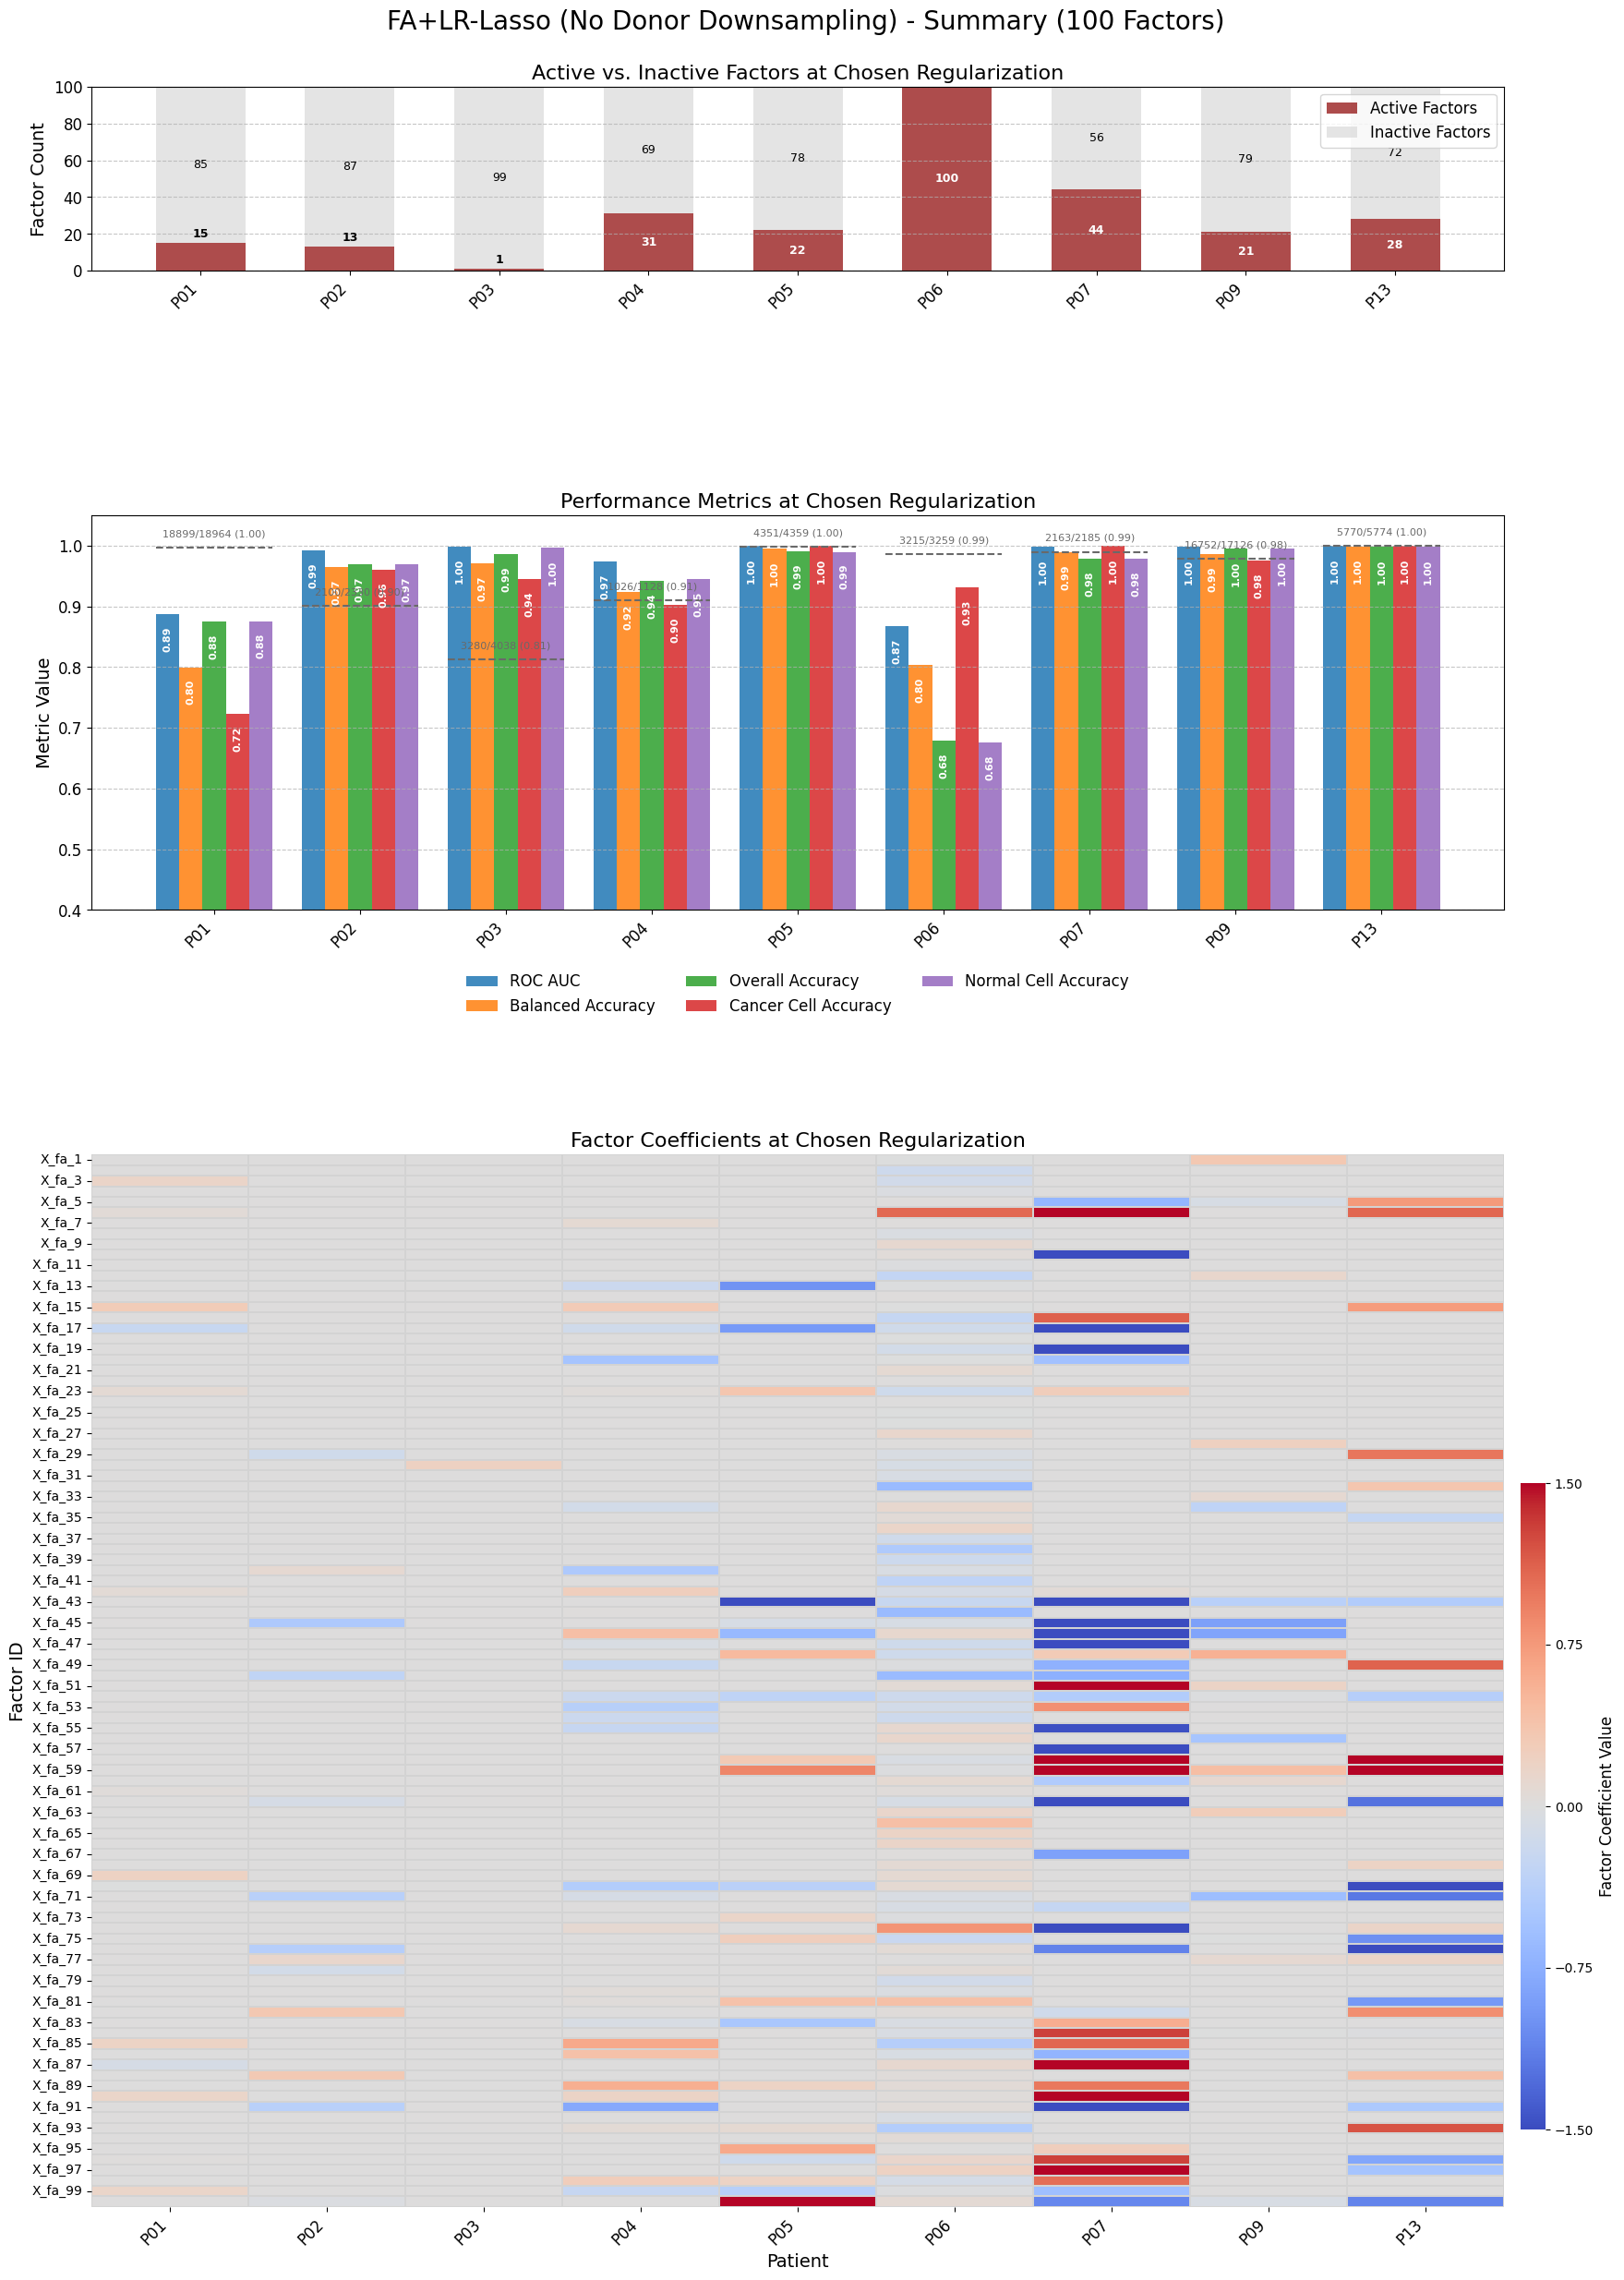

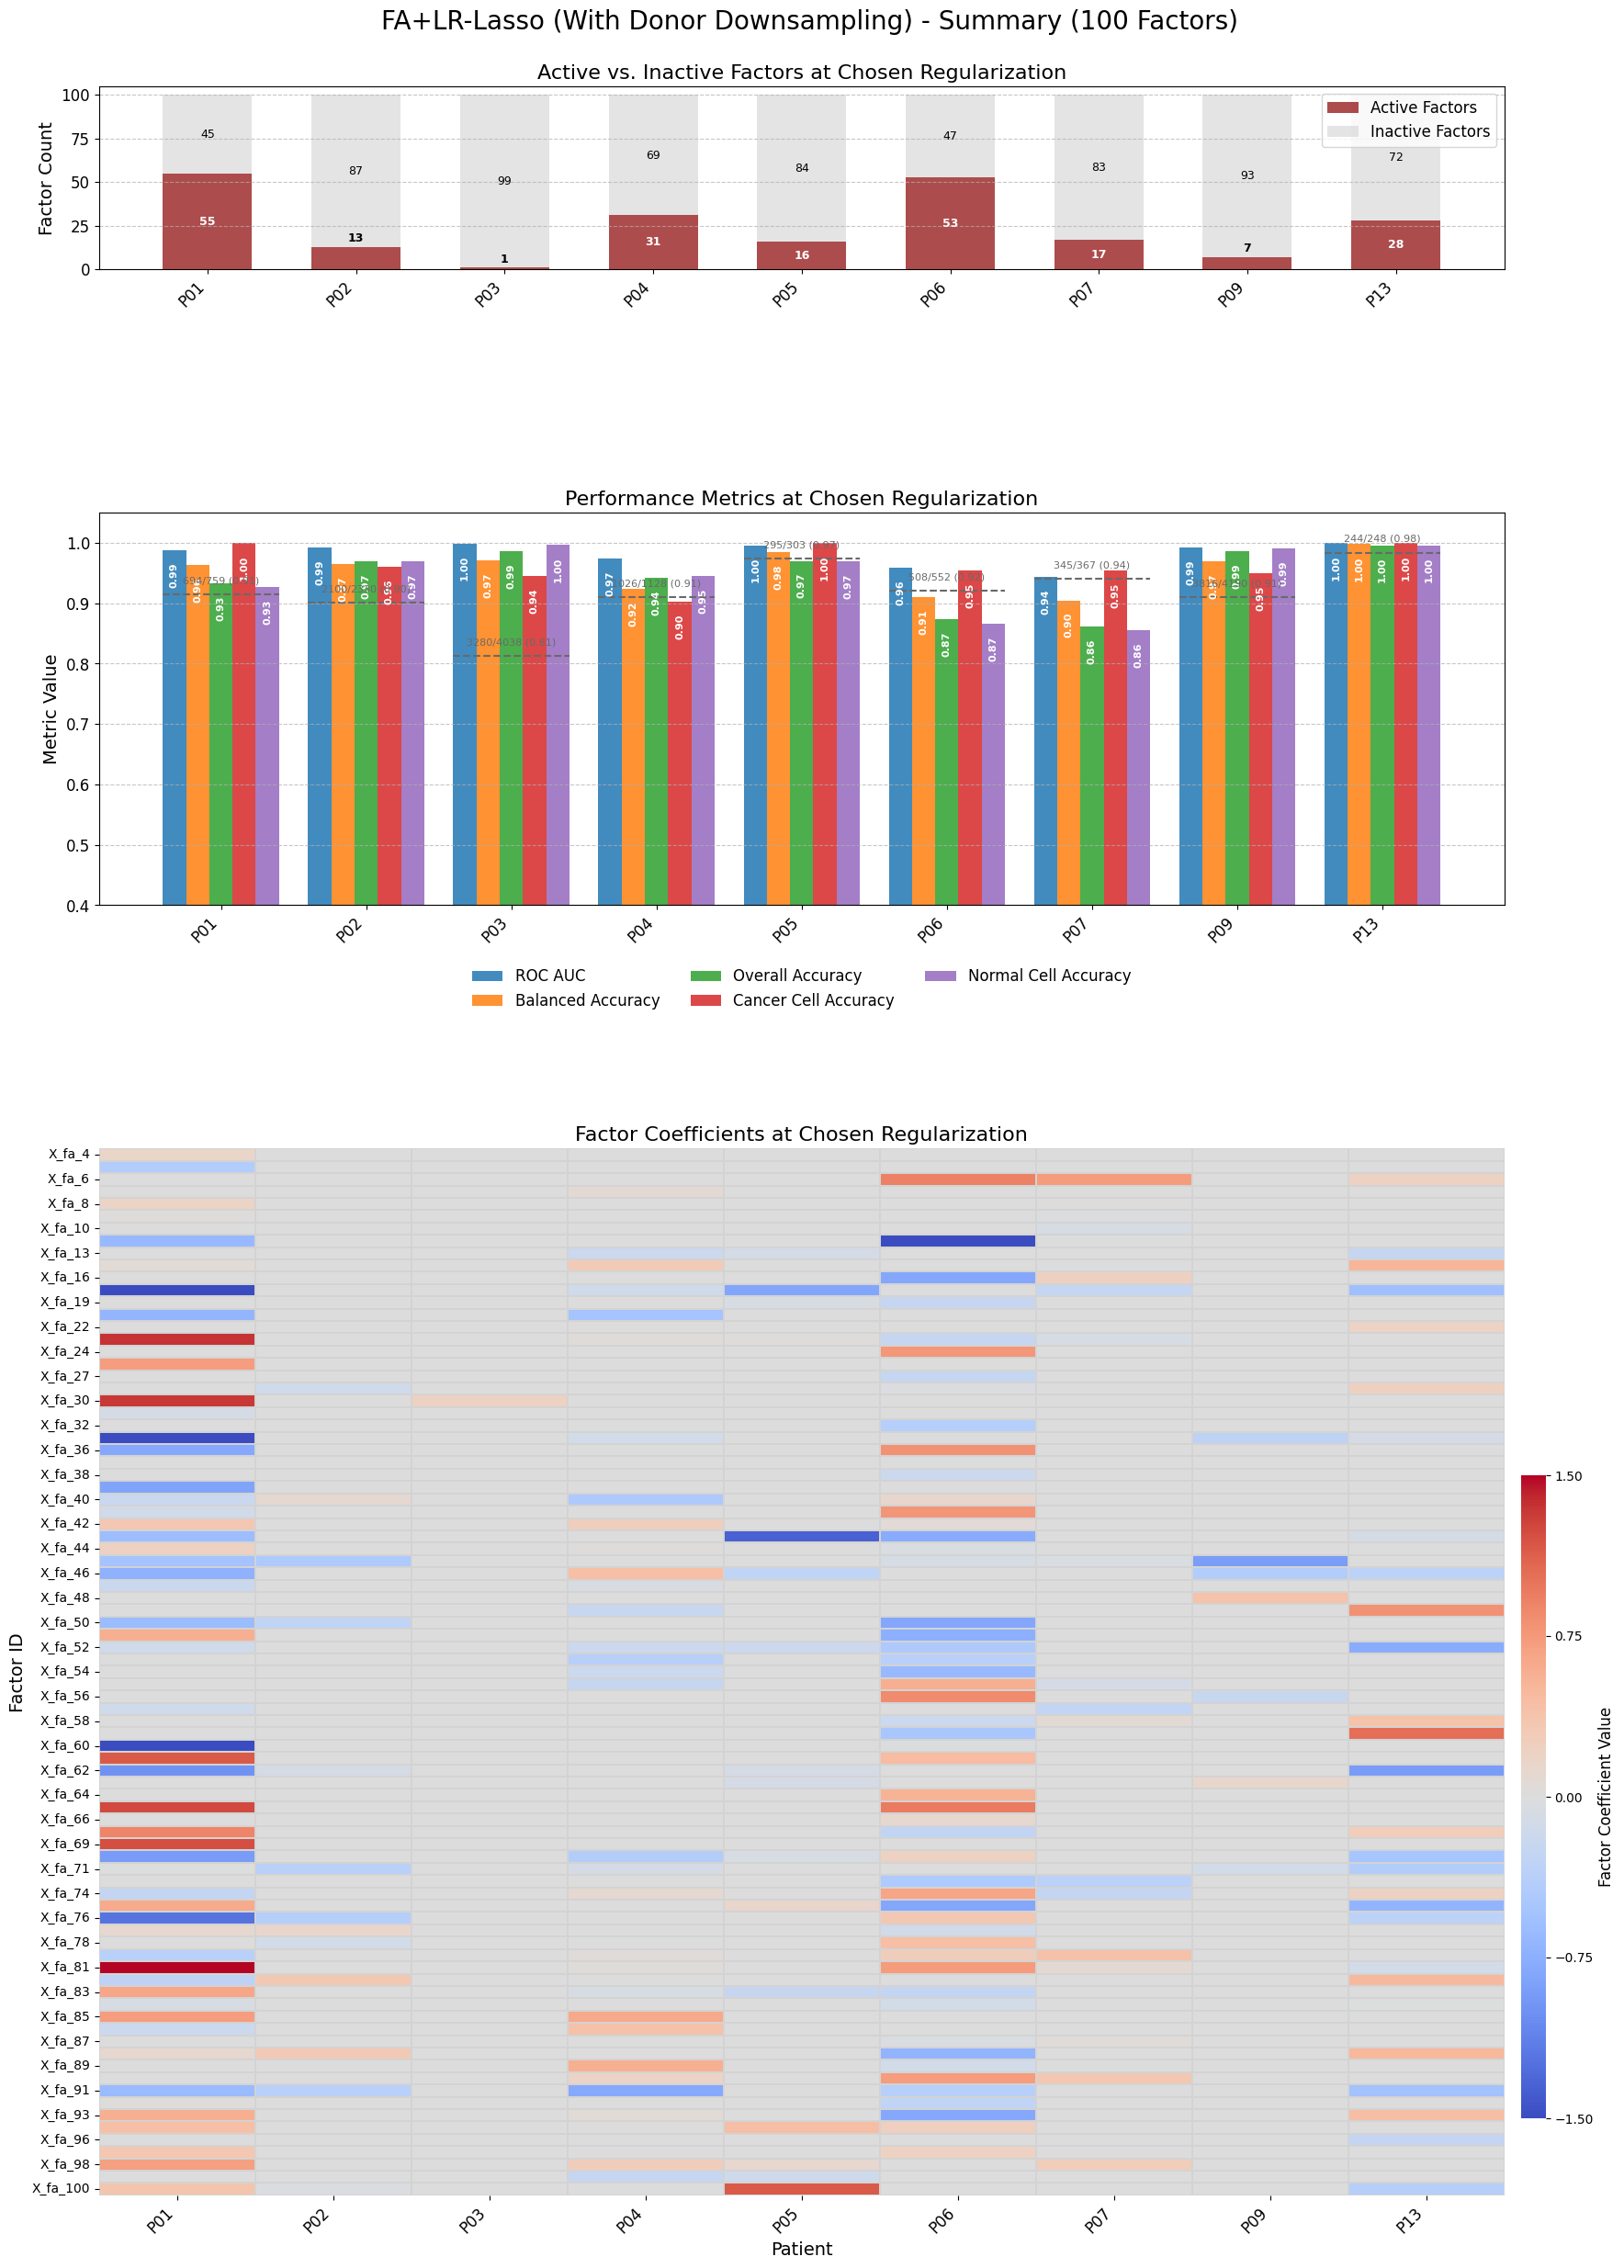

In [6]:
# --- Define Hand-Picked Alpha Indices (1-based) ---
# YOU NEED TO FILL THESE DICTIONARIES BASED ON YOUR PLOTS
# Example: if for P01, the 10th alpha in ALPHAS_LASSO was chosen: {'P01': 10, ...}
N_FACTORS_TO_PLOT = 100

# For results WITHOUT downsampling
BASE_DIR_NO_DS = '../pipeline/results_fa_lrlasso_mrd_pipeline_prestd_hvg_may31' 
# Example: User needs to inspect their plots and choose the alpha_idx (1 to 20)
# This is crucial and depends on your interpretation of the per-patient plots.
hand_picked_alphas_no_ds = {
    "P01": 16, 
    "P02": 13, # 14 potentially
    "P03": 17,
    "P04": 12,
    "P05": 12, # 12 potentially
    "P06": 13, # 9 potentially
    "P07": 10, # 9 potentially
    "P09": 14,
    "P13": 11 # 12 potentially
} # Placeholder - REPLACE WITH YOUR ACTUAL CHOSEN INDICES

# For results WITH donor downsampling
BASE_DIR_WITH_DS = '../pipeline/results_fa_lrlasso_mrd_pipeline_donor_downsampled_projection_ready_may31'
hand_picked_alphas_with_ds = {
    "P01": 10, 
    "P02": 13, # 14 potentially
    "P03": 17,
    "P04": 12,
    "P05": 11, # 12 potentially
    "P06": 10, # 9 potentially
    "P07": 12, # 9 potentially
    "P09": 14,
    "P13": 10 # 12 potentially
} # Placeholder - REPLACE WITH YOUR ACTUAL CHOSEN INDICES


# --- Function to orchestrate data extraction and plotting ---
def generate_summary_for_scenario(base_dir, hand_picked_indices, n_factors, title_prefix_plot, output_plot_filename):
    patient_metrics_agg = {}
    patient_coefficients_agg = {}
    
    # Get a list of patients actually present in the results for this n_factors
    # This assumes patient folders are named "patient_PXX"
    n_factors_path = os.path.join(base_dir, f"n_factors_{n_factors}")
    if not os.path.isdir(n_factors_path):
        print(f"Directory not found for {n_factors} factors: {n_factors_path}")
        return

    available_patients = sorted([
        d.replace("patient_", "") for d in os.listdir(n_factors_path) 
        if d.startswith("patient_P") and os.path.isdir(os.path.join(n_factors_path, d))
    ])
    
    print(f"\n--- Aggregating data for: {title_prefix_plot} ({n_factors} Factors) ---")
    for p_id in available_patients:
        if p_id not in hand_picked_indices:
            print(f"  Patient {p_id}: No hand-picked alpha index provided. Skipping.")
            continue
        
        alpha_idx_1based = hand_picked_indices[p_id]
        print(f"  Processing Patient {p_id} with 1-based alpha index {alpha_idx_1based}...")
        
        eff_alpha, metrics, coeffs = extract_patient_data_at_alpha_idx(
            base_dir, n_factors, p_id, alpha_idx_1based, ALPHAS_LASSO
        )
        if metrics is not None and coeffs is not None:
            patient_metrics_agg[p_id] = metrics
            patient_coefficients_agg[p_id] = coeffs
        else:
            print(f"  Could not extract data for Patient {p_id}.")
            
    if patient_metrics_agg and patient_coefficients_agg:
        print(f"\n--- Creating summary plot for: {title_prefix_plot} ---")
        create_fa_summary_plot(
            patient_metrics_agg, 
            patient_coefficients_agg,
            title_prefix=title_prefix_plot,
            output_filename=output_plot_filename
        )
    else:
        print(f"No data aggregated for plotting for {title_prefix_plot}. Plot not generated.")

# --- Generate plot for NO DOWNSAMPLING ---
output_dir_plots = "summary_plots_fa_lasso" # Define where to save these summary plots
os.makedirs(output_dir_plots, exist_ok=True)

generate_summary_for_scenario(
    BASE_DIR_NO_DS,
    hand_picked_alphas_no_ds,
    N_FACTORS_TO_PLOT,
    title_prefix_plot="FA+LR-Lasso (No Donor Downsampling)",
    output_plot_filename=os.path.join(output_dir_plots, f"summary_plot_{N_FACTORS_TO_PLOT}factors_NO_DS.png")
)

# --- Generate plot WITH DOWNSAMPLING ---
generate_summary_for_scenario(
    BASE_DIR_WITH_DS,
    hand_picked_alphas_with_ds,
    N_FACTORS_TO_PLOT,
    title_prefix_plot="FA+LR-Lasso (With Donor Downsampling)",
    output_plot_filename=os.path.join(output_dir_plots, f"summary_plot_{N_FACTORS_TO_PLOT}factors_WITH_DS.png")
)

print("\nSummary plot generation finished.")